In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo


In [2]:
FASTA="/home/serge/deepcelllineage/mitolin/data/gen/nguyen_nc_2018/20190702-fastas-on-hpc/1739/20lines/"

In [3]:
labels = []
ff = glob.glob(f"{FASTA}*.fasta")
fsts = []
sequences = []
for file in ff:
    label = file.split("/")[-1].split("_")[0]
    labels.append(label)
    for record in SeqIO.parse(file, "fasta"):
        fsts.append(list(str(record.seq))) 
        record.id=label;record.name=label;record.description=f"{label} chrM"
        sequences.append(record)

In [4]:
labels

['A04', 'A01', 'A07', 'A09', 'A06', 'A10', 'A12', 'A05', 'A03']

In [5]:
diffs = [[0. for x in range(len(fsts))] for y in range(len(fsts))]
bits = {}
for i in range(0, len(fsts)):
        for j in range (0, len(fsts)):
            cntr = 0
            bit = np.zeros(len(fsts[i]),dtype=int)
            for k in range(len(fsts[i])):
                if fsts[i][k] != fsts[j][k]: cntr +=1; bit[k] =  1
            bits[(labels[i],labels[j])] = bit
            diffs[i][j] = (1 - cntr/len(fsts[i]))*100

In [6]:
sum(bits[("A12","A07")])

0

A03 and A04 are different in 5 mutations in respect to A01

In [7]:
[(i,("A01",fsts[0][i]), ("A03", fsts[labels.index("A03")][i]), ("A04",fsts[labels.index("A04")][i])) 
     for i, b in enumerate(bits[("A01","A03")] != bits[("A01","A04")]) if b]

[(149, ('A01', 'C'), ('A03', 'T'), ('A04', 'C')),
 (194, ('A01', 'C'), ('A03', 'T'), ('A04', 'C')),
 (722, ('A01', 'T'), ('A03', 'C'), ('A04', 'T')),
 (822, ('A01', 'T'), ('A03', 'C'), ('A04', 'T')),
 (962, ('A01', 'T'), ('A03', 'A'), ('A04', 'T'))]

In [8]:
df=pd.DataFrame(data=diffs, columns = labels, index=labels)            

In [9]:
df

,A04,A01,A07,A09,A06,A10,A12,A05,A03
A04,100.000000,90.701754,99.912281,99.824561,78.421053,46.140351,99.912281,89.122807,99.561404
A01,90.701754,100.000000,90.789474,90.701754,80.175439,45.964912,90.789474,80.000000,90.438596
A07,99.912281,90.789474,100.000000,99.912281,78.333333,46.052632,100.000000,89.035088,99.649123
A09,99.824561,90.701754,99.912281,100.000000,78.333333,46.140351,99.912281,88.947368,99.561404
A06,78.421053,80.175439,78.333333,78.333333,100.000000,47.105263,78.333333,67.807018,78.333333
A10,46.140351,45.964912,46.052632,46.140351,47.105263,100.000000,46.052632,46.403509,46.140351
A12,99.912281,90.789474,100.000000,99.912281,78.333333,46.052632,100.000000,89.035088,99.649123
A05,89.122807,80.000000,89.035088,88.947368,67.807018,46.403509,89.035088,100.000000,88.859649
A03,99.561404,90.438596,99.649123,99.561404,78.333333,46.140351,99.649123,88.859649,100.000000


In [10]:
word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v')

In [11]:
X = []
for seq in fsts:
    vectors = word_vectors[["".join(seq[i:i+10]) for i in range(len(seq)-10)]]
    X.append(np.sum(vectors, axis=0))

CPU times: user 1.02 ms, sys: 0 ns, total: 1.02 ms
Wall time: 755 µs


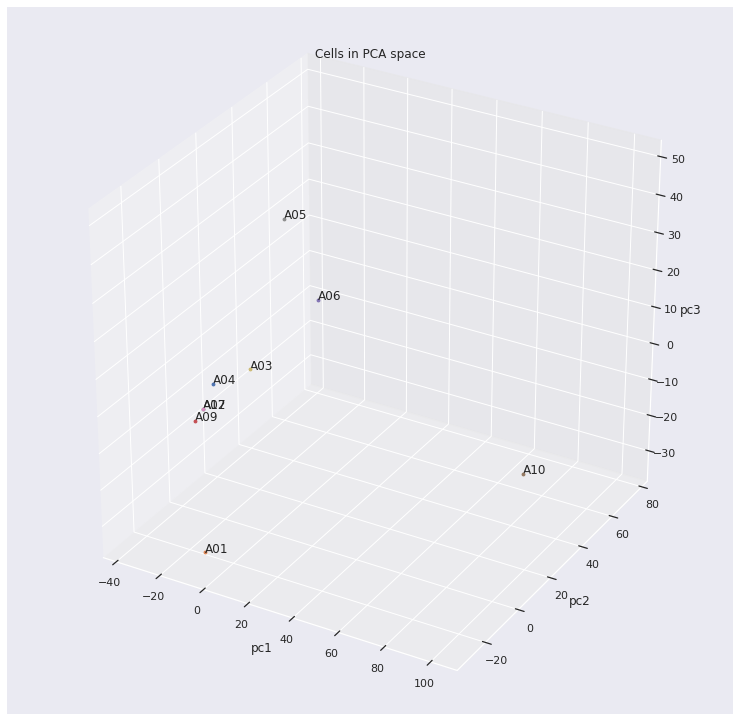

In [22]:
pca = PCA(n_components=3)
%time X3 = pca.fit_transform(X)
X3_df = pd.DataFrame(data=X3, columns=["pc1",'pc2',"pc3"], index=labels)

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
for cell in X3_df.index:
    ax.scatter(X3_df.loc[cell,"pc1"],X3_df.loc[cell,"pc2"],X3_df.loc[cell,"pc3"], marker="o",s=8, label = cell)
    ax.text(X3_df.loc[cell,"pc1"],X3_df.loc[cell,"pc2"],X3_df.loc[cell,"pc3"], cell, size=12)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
ax.set_title("Cells in PCA space")
plt.show()

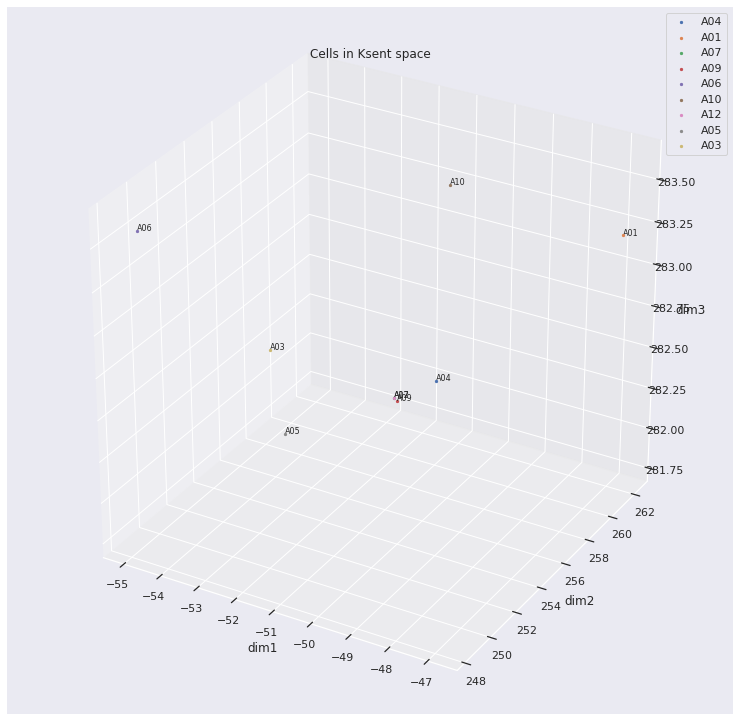

In [23]:
import sys, os
sys.path.append(".")
from KlsAutoencoder import *
e = Encoder("../data/models/encoder-3d",[100,50,3]);e

data = e.encode(X)

fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
for i, cell in enumerate(labels):
    ax.scatter(data[i,0],data[i,1],data[i,2], marker="o",s=5, label = cell)
    ax.text(data[i,0],data[i,1],data[i,2], cell, size=8)
ax.set_xlabel('dim1')
ax.set_ylabel('dim2')
ax.set_zlabel('dim3')
ax.set_title("Cells in Ksent space")
plt.legend()
plt.show()

## Build phylogenetic tree using  Ksent Cosign  (my method) 

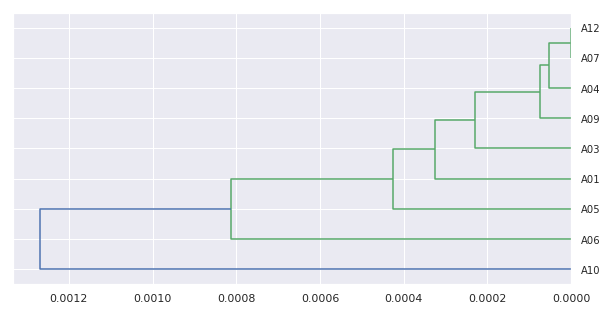

In [49]:
linked = linkage(X, method='average', metric="cosine")
fig=plt.figure(figsize=(10, 5)) 
ax1 = fig.add_subplot(111)

htree = dendrogram(linked,  
            ax=ax1,
            orientation='left',
            p=data.shape[0],
            truncate_mode='lastp',
            leaf_font_size = 10,
            labels=labels,
            distance_sort='descending',
            show_contracted=True,       
            show_leaf_counts=True)

## Build  maximum likelyhood phylogenetic tree (conventional UPGMA method)

In [40]:
import matplotlib as matplotlib

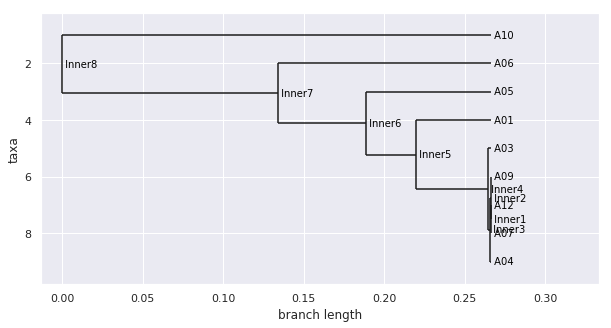

In [46]:
alignment = MultipleSeqAlignment(sequences)
calculator = DistanceCalculator("identity") 
tree = DistanceTreeConstructor(calculator, "upgma").build_tree(alignment)
matplotlib.rcParams.update({'figure.figsize': (10,5),
                            'font.size': 10})
Phylo.draw(tree)

In [37]:
Phylo.draw??

### Observations

- It seems that for the given 9 cells from LaBrock study produce similar clustering models. 
- The A05,A10,A06,A01 tree of the conventional method can be seen in the tree using my proposed method. 
- The A09, A03, A04, A07 and A12 have no relationship the conventional model and do have a relationship in my model.